In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from tensorflow.keras.datasets import cifar100, cifar10
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import sys
sys.path.append("../")

In [2]:
data = cifar10.load_data()

In [3]:
x_test = data[1][0].astype(float)
y_test = data[1][1].flatten()

In [4]:
y_test = to_categorical(y_test, num_classes=10)

In [5]:
from tensorflow.keras import models
import sys

In [ ]:
sys.path.append("models/")
model_cifar10 = models.load_model("models/resnet50model_cifar10.h5")

In [7]:
preds = model_cifar10.predict(x_test)

In [8]:
(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)).sum()

7984

In [9]:
import sys
sys.path.append("attacks/")
sys.path.append("utils/")

import utils
from data_manager import load_data

# Black Box Attacks
import random_noise
import EvoStrategy
import SimbaWrapper

In [10]:
model = model_cifar10

In [11]:
import gc
gc.collect()

274

In [12]:
preds = model.predict(x_test)

In [13]:
pred_labels = np.argmax(preds, axis=1)

In [14]:
true_labels = np.argmax(y_test, axis=1)

In [15]:
acc = np.sum(pred_labels == true_labels) / len(y_test)

In [16]:
acc

0.7984

In [17]:
np.shape(x_test[0])

(32, 32, 3)

In [213]:
x_test_correct = x_test[pred_labels == true_labels]
y_test_correct = y_test[pred_labels == true_labels]

Step 1999 / 2000
Previous robustness:  0.115


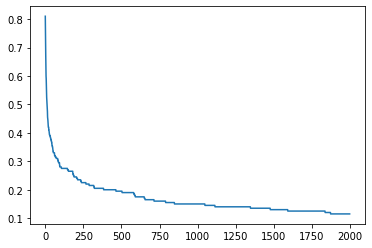

In [393]:
importlib.reload(random_noise)

agreements_cell_test, saved_noisy_imgs_cell_test, number_queries = random_noise.check_noise_robustness_multiple_rounds(
    model,                  # model to attack
    x_test_correct[:200],           # sample images to attack
    y_test_correct[:200],    # correct labels of the sample images
    2000,                      # max number of steps to run the attack for
    noise_type="cells",      # 'cells' by default, it is gaussian noise added to a random set of pixels
    args={
        "cell_count":33, # as CIFAR10 has 3 channels, the L0 will be 3*cell_count
        "normalize":1
    }   # 'cell_count' is how many pixels to randomly perturb at maximum; so l0 distance <= cell_count value
)

In [500]:
len(number_queries)/200

0.695

In [404]:
np.mean(list(number_queries.values()))

159.32374100719426

In [397]:
saved_noise_array = np.array(saved_noisy_imgs_cell_test)[np.invert(agreements_cell_test)]
original_images = np.array(x_test_correct[:200])[np.invert(agreements_cell_test)]
diffs = []
for x in range(len(original_images)):
    diff = abs(saved_noise_array[x] - original_images[x])
    diffs.append(diff)

In [564]:
import math
l2_dists = []
for x in diffs:
    l2_dists.append(math.sqrt(np.sum(x ** 2)))

In [565]:
np.mean(l2_dists)/255

3.890088443751095

In [401]:
l0_dists = []
for x in diffs:
    l0_dists.append(np.sum(x!=0))

In [402]:
np.mean(l0_dists)

97.16949152542372

In [391]:
# plt.imshow(saved_noisy_imgs_cell_test[2])
print("correct label:", y_test_correct[3])
print("after:", np.argmax(model.predict(np.expand_dims(saved_noisy_imgs_cell_test[3], 0)), axis=1)[0])
print("initially:", np.argmax(model.predict(np.expand_dims(x_test_correct[3], 0)), axis=1)[0])
print(model.predict(np.expand_dims(saved_noisy_imgs_cell_test[3], 0)))
print(model.predict(np.expand_dims(x_test_correct[3], 0)))
print("queries:", number_queries[3])

correct label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
after: 8
initially: 0
[[1.6558166e-01 1.0804423e-03 9.6956227e-04 2.2843029e-02 1.2496864e-02
  2.2430078e-04 2.1743183e-03 3.4578945e-03 7.4248195e-01 4.8689984e-02]]
[[9.9163252e-01 7.1678858e-04 3.0690408e-05 1.3989178e-04 4.7649060e-05
  3.6667752e-06 5.1356701e-06 1.9148905e-05 6.9927992e-03 4.1172121e-04]]
queries: 0


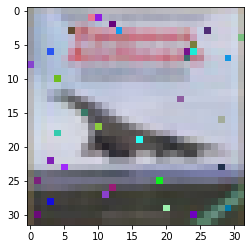

In [392]:
plt.imshow(saved_noisy_imgs_cell_test[3]/255)

In [214]:
importlib.reload(SimbaWrapper)
# SAMPLE_SIZE = len(x_test_sample)
SAMPLE_SIZE = 200

simba_wrapper = SimbaWrapper.SimbaWrapper(
    model=model, 
    X=x_test_correct[:SAMPLE_SIZE], 
    y=y_test_correct[:SAMPLE_SIZE], 
    epsilon=0.2, 
    max_queries=4000, 
    max_l0_distance=32*32, 
    max_iterations = 2000,
    folder="cifar_simba",
    verbose=False,
    max_value=255.0
)

In [215]:
simba_wrapper.run_simba()

100%|██████████| 200/200 [1:40:35<00:00, 30.18s/it]  


In [216]:
np.sum(simba_wrapper.perturbed)

198

In [217]:
np.mean(simba_wrapper.queries)

240.09

In [218]:
np.median(simba_wrapper.queries)

167.0

In [219]:
(np.abs(simba_wrapper.X_modified[6] - simba_wrapper.X[0])!=0).sum()

3061

In [220]:
np.argmax(model.predict(np.array([simba_wrapper.X_modified[1]])), axis=1)

array([1])

In [221]:
np.argmax(np.array([simba_wrapper.y[1]]))

8

In [222]:
np.argmax(model.predict(np.array([simba_wrapper.X[1]])), axis=1)

array([8])

In [223]:
simba_wrapper.X_modified[1].max()

255.0

In [224]:
np.mean(simba_wrapper.l0_distances)

99.14

In [225]:
import math
l2_dists_simba = []
for index_diff in tqdm(range(50)):
    diff = np.abs(simba_wrapper.X_modified[index_diff] - simba_wrapper.X[index_diff])
#     diff = np.reshape(diff, (32, 32, 3))
    l2_dist = math.sqrt(np.sum(np.reshape(diff, (-1))**2))
    l2_dists_simba.append(l2_dist)
#     print("L2 distance:", math.sqrt(np.sum(np.reshape(diff, (-1))**2)))
#     plt.imshow(np.reshape(adv_evo_strategy[index_diff].get_best_candidate(), (28, 28)))
#     plt.show()
#     print("Prediction:", model.predict(np.array([adv_evo_strategy[index_diff].get_best_candidate()])))

100%|██████████| 50/50 [00:00<00:00, 634.04it/s]


In [226]:
np.mean(l2_dists_simba)/255

1.6563481544653615

In [227]:
np.median(l2_dists_simba)

384.8036513185099

In [ ]:
# sa rulez simba pe 1000 de imagini (pe cifar), tabel cu reported results from the authors + our results for simba
# si strategia noastra pe 1000 de imagini de imagenet

In [ ]:
# Randomness + information in BBA
# baseline: pur random. EvoStrategy: permite o folosire mai buna a informatiei (decat SimBA)
# strategia extrem de simpla, smart/advanced baseline
# de trimis related work cu evo strategies pe BBA
# abs: BBA mai dificile, au nevoie de randomness, dar si sa fol info obtinuta.
#    propunem .. care depaseste .., putand deveni un smart baseline pentru alte metode de AA
#    scopul atacului este l0, dar raportam si l2

# 50 de imag din imagenet macar (resnet50, inceptionv3 altfel)

In [186]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [189]:
importlib.reload(EvoStrategy)
import json
import time
import datetime
from pathlib import Path

GENERATION_SIZE = 30
PIXEL_COUNT = 1
STEPS = 200

# RESTART = True
RESTART = False

if RESTART:
    RESTART_FILE_INDEX = 14
    TIMESTAMP = "2020-11-18 23:48:56.704612"
    RESTART_INDEX = RESTART_FILE_INDEX * 100 + 1
    with open(f"saved_experiments/{TIMESTAMP}/{RESTART_FILE_INDEX}.json") as fp:
        json_saved_results = json.load(fp)
        perturbed_images = json_saved_results["perturbed"]
        queries = json_saved_results["queries"]
        best_candidates = json_saved_results["best_candidates"]
else:
    RESTART_INDEX = 0
    TIMESTAMP = str(datetime.datetime.now())
    perturbed_images = 0
    queries = []
    best_candidates = []


print("START")
print("Experiment TIMESTAMP:", TIMESTAMP)
print("RESTART_INDEX:", RESTART_INDEX)
print("perturbed_images:", perturbed_images)

VERBOSE = False

adv_evo_strategy = {}

# SIZE = len(x_test_correct)
SAVE = True
SIZE = 2000

BASE = "saved_experiments_cifar10"
Path(BASE).mkdir(exist_ok=True)

Path(BASE + "/" + TIMESTAMP).mkdir(exist_ok=True)

CLEAR_MEMORY = False

BACKUP_STEP = 100
for index in tqdm(range(RESTART_INDEX, SIZE)):
    if VERBOSE:
        print()
        print(index)
    img = x_test_correct[index]
    label = np.argmax(y_test_correct[index])
    adv_evo_strategy[index] = EvoStrategy.AdversarialPerturbationEvoStraegy(
        model=model,
        img=img,
        label=label,
        generation_size=GENERATION_SIZE, 
        one_step_perturbation_pixel_count=PIXEL_COUNT,
        verbose=VERBOSE,
        zero_one_scale=False
    )
    no_steps = adv_evo_strategy[index].run_adversarial_attack(steps=STEPS)
    if adv_evo_strategy[index].stop_criterion() and no_steps > 0:
        perturbed_images += 1
        queries.append(adv_evo_strategy[index].queries)
    else:
        queries.append(-1)
    
    if(index % BACKUP_STEP == 0 and SAVE):
        file_count = (index + 1) // BACKUP_STEP
        queries_successful = list(filter(lambda x: x!=-1, queries))
    
        save_data = {
            "queries": queries,
            "count": index + 1,
            "perturbed": perturbed_images,
            "avg_queries": sum(queries_successful) / len(queries_successful),
            "best_candidates": best_candidates
        }
        with open(f"{BASE}/{TIMESTAMP}/{file_count}.json", 'w') as fp:
            json.dump(save_data, fp, cls=NumpyEncoder)
            print(f"Saved file {file_count}")
        gc.collect()
    
    best_candidates.append(adv_evo_strategy[index].get_best_candidate())
    
    if CLEAR_MEMORY:
        adv_evo_strategy[index] = {}

  0%|          | 0/2000 [00:00<?, ?it/s]

START
Experiment TIMESTAMP: 2021-02-15 00:33:34.302374
RESTART_INDEX: 0
perturbed_images: 0


  0%|          | 1/2000 [00:03<2:08:34,  3.86s/it]

Saved file 0


  5%|▌         | 100/2000 [03:11<1:12:44,  2.30s/it]

Saved file 1


 10%|█         | 200/2000 [06:15<1:19:43,  2.66s/it]

Saved file 2


 15%|█▌        | 300/2000 [09:35<1:10:00,  2.47s/it]

Saved file 3


 20%|██        | 400/2000 [13:00<42:32,  1.60s/it]  

Saved file 4


 25%|██▌       | 500/2000 [16:52<59:27,  2.38s/it]  

Saved file 5


 30%|███       | 600/2000 [20:15<52:42,  2.26s/it]  

Saved file 6


 35%|███▌      | 700/2000 [23:51<44:18,  2.05s/it]  

Saved file 7


 40%|████      | 800/2000 [27:25<1:00:07,  3.01s/it]

Saved file 8


 45%|████▌     | 900/2000 [31:02<56:10,  3.06s/it]  

Saved file 9


 50%|█████     | 1000/2000 [34:35<43:37,  2.62s/it] 

Saved file 10


 55%|█████▌    | 1100/2000 [37:57<33:17,  2.22s/it]  

Saved file 11


 60%|██████    | 1200/2000 [41:37<53:02,  3.98s/it]  

Saved file 12


 65%|██████▌   | 1300/2000 [45:07<21:10,  1.82s/it]  

Saved file 13


 70%|███████   | 1400/2000 [48:45<34:28,  3.45s/it]  

Saved file 14


 75%|███████▌  | 1500/2000 [52:08<16:24,  1.97s/it]  

Saved file 15


 80%|████████  | 1600/2000 [56:12<15:58,  2.40s/it]  

Saved file 16


 85%|████████▌ | 1700/2000 [1:00:04<08:48,  1.76s/it]

Saved file 17


 90%|█████████ | 1800/2000 [1:04:02<06:08,  1.84s/it]

Saved file 18


 95%|█████████▌| 1900/2000 [1:07:42<02:29,  1.50s/it]

Saved file 19


100%|██████████| 2000/2000 [1:11:37<00:00,  2.15s/it]


In [356]:
perturbed_images

2000

In [191]:
queries_mean = np.mean(queries)

In [192]:
queries_median = np.median(queries)

In [295]:
queries.sort()

In [355]:
x

array([  31,   31,   31, ..., 1051, 1081, 1081])

In [337]:
def get_empirical_distribution(queries_in, count_images):
    queries = queries_in.copy()
    queries.sort()
    list_x = [0]
    list_y = [0]
    max_q = max(queries)
    for x in range(len(queries)):
        if x == len(queries) - 1:
            list_x.append(queries[x])
            list_y.append((x + 1) / perturbed_images)
        elif queries[x] != queries[x+1]:
            list_x.append(queries[x])
            list_y.append((x + 1) / perturbed_images)
    return list_x, list_y

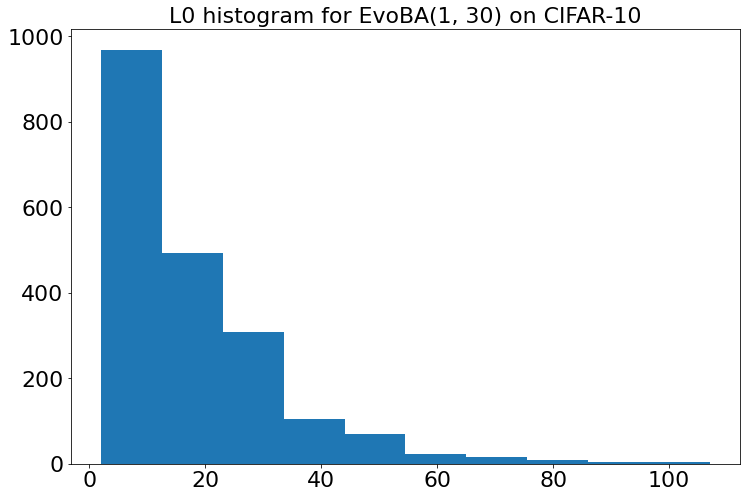

In [485]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,8))
plt.title("L0 histogram for EvoBA(1, 30) on CIFAR-10", fontdict={"size":22})
plt.hist(l0_dists)
plt.show()

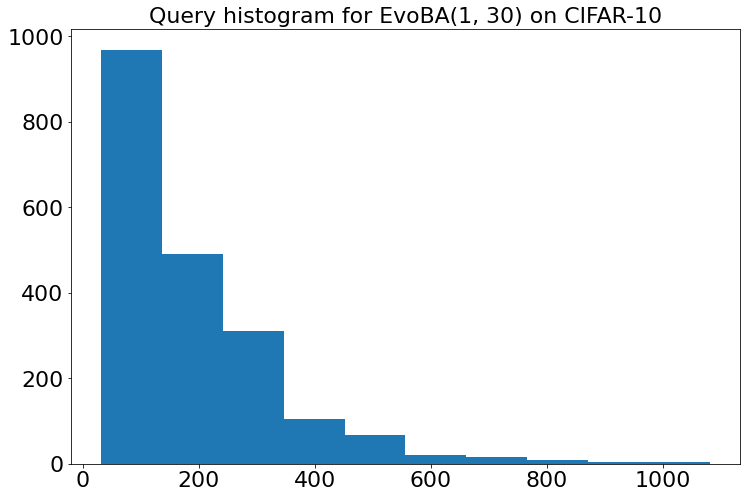

In [480]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,8))
plt.title("Query histogram for EvoBA(1, 30) on CIFAR-10", fontdict={"size":22})
plt.hist(queries)
plt.show()

In [338]:
list_x_evoba, list_y_evoba = get_empirical_distribution(queries, len(queries))

In [348]:
simba_q = np.array(simba_wrapper.queries)[simba_wrapper.perturbed]
simba_q.sort()

list_x_simba, list_y_simba = get_empirical_distribution(simba_q, len(simba_wrapper.perturbed))

In [437]:
random_q = list(number_queries.values())
random_q.sort()

list_x_random, list_y_random = get_empirical_distribution(random_q, len(agreements_cell_test))

list_x_random.append(np.max(list_x_simba))
list_y_random.append(list_y_random[len(list_y_random)-1])

In [428]:
random_q_mean = np.mean(random_q)
random_q_median = np.median(random_q)

In [349]:
# BINS = 2000
# max_range = max(queries)
# bins_list = np.array(range(BINS)) * max_range/BINS

# res = plt.hist(queries, cumulative=True, histtype='step', density=True, bins=bins_list)
# res_y = [0]+list(res[0])
# res_x = [0]+list(res[1][:BINS-1])

In [350]:
# with open("cifar_simba/4.json", "r") as f:
#     data_cifar_simba = json.load(f)

In [351]:
# BINS = 200
# max_range = max(simba_wrapper.queries)
# bins_list = np.array(range(BINS)) * max_range/BINS

# res = plt.hist(simba_wrapper.queries, cumulative=True, histtype='step', density=True, bins=bins_list)
# res_y_simba = [0]+list(res[0])
# res_x_simba = [0]+list(res[1][:BINS-1])

# queries_mean_simba = np.mean(simba_wrapper.queries)
# queries_median_simba = np.median(simba_wrapper.queries)

In [353]:
int(True)

1

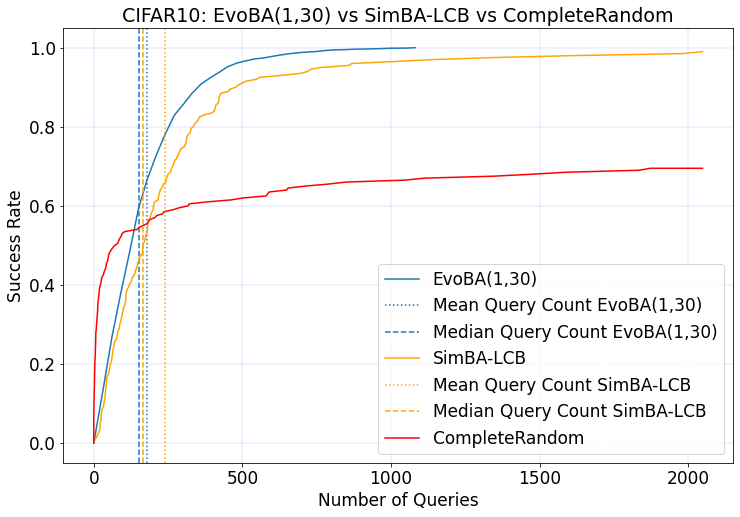

In [490]:
# BINS = 30
plt.rcParams.update({'font.size': 17})

plt.figure(figsize=(12,8))
plt.title("CIFAR10: EvoBA(1,30) vs SimBA-LCB vs CompleteRandom", fontdict={"size":19})
plt.grid(color='b', ls = '-.', lw = 0.15)
# plt.xlim(0,np.max(queries))
# plt.axhline(y=1, linestyle=':')
plt.plot(list_x_evoba, list_y_evoba, label="EvoBA(1,30)")
plt.axvline(x=queries_mean, linestyle=':', label="Mean Query Count EvoBA(1,30)")
plt.axvline(x=queries_median, linestyle='dashed', label="Median Query Count EvoBA(1,30)")

plt.plot(list_x_simba, list_y_simba, color='orange', label="SimBA-LCB")
plt.axvline(x=queries_mean_simba, linestyle=':', label="Mean Query Count SimBA-LCB", color='orange')
plt.axvline(x=queries_median_simba, linestyle='dashed', label="Median Query Count SimBA-LCB", color='orange')

plt.plot(list_x_random, list_y_random, color='red', label="CompleteRandom")
# plt.axvline(x=random_q_mean, linestyle=':', label="Mean Query Count SimBA", color='red')
# plt.axvline(x=random_q_median, linestyle='dashed', label="Median Query Count SimBA", color='red')

plt.legend(loc='lower right')

plt.xlabel('Number of Queries')
plt.ylabel('Success Rate')

plt.show()

[0,
 0.005050505050505051,
 0.010101010101010102,
 0.015151515151515152,
 0.020202020202020204,
 0.030303030303030304,
 0.03535353535353535,
 0.04040404040404041,
 0.050505050505050504,
 0.05555555555555555,
 0.07575757575757576,
 0.08080808080808081,
 0.08585858585858586,
 0.09090909090909091,
 0.09595959595959595,
 0.10101010101010101,
 0.10606060606060606,
 0.1111111111111111,
 0.12626262626262627,
 0.13636363636363635,
 0.1414141414141414,
 0.15656565656565657,
 0.16666666666666666,
 0.1717171717171717,
 0.17676767676767677,
 0.18686868686868688,
 0.1919191919191919,
 0.19696969696969696,
 0.20202020202020202,
 0.20707070707070707,
 0.2222222222222222,
 0.22727272727272727,
 0.23737373737373738,
 0.2474747474747475,
 0.25252525252525254,
 0.25757575757575757,
 0.2676767676767677,
 0.2777777777777778,
 0.2878787878787879,
 0.29292929292929293,
 0.30303030303030304,
 0.30808080808080807,
 0.31313131313131315,
 0.3181818181818182,
 0.32323232323232326,
 0.3333333333333333,
 0.33838383

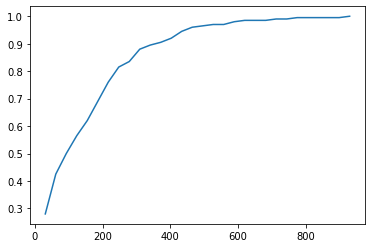

In [117]:
plt.plot(res[1][:],res[0])

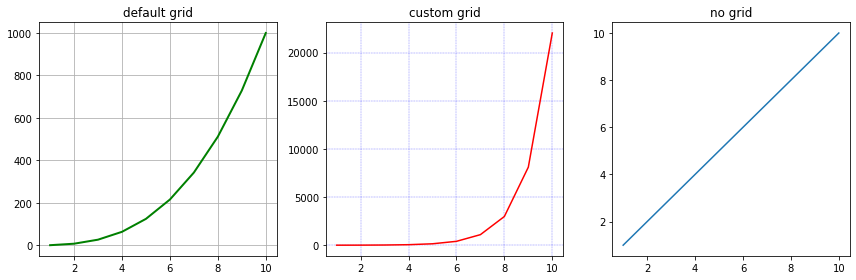

In [77]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
x = np.arange(1,11)
axes[0].plot(x, x**3, 'g',lw=2)
axes[0].grid(True)
axes[0].set_title('default grid')
axes[1].plot(x, np.exp(x), 'r')
axes[1].grid(color='b', ls = '-.', lw = 0.25)
axes[1].set_title('custom grid')
axes[2].plot(x,x)
axes[2].set_title('no grid')
fig.tight_layout()
plt.show()

In [23]:
np.quantile(queries,0.5)

136.0

(array([4.60784314e-03, 2.45098039e-03, 1.27450980e-03, 6.86274510e-04,
        2.94117647e-04, 1.96078431e-04, 0.00000000e+00, 1.96078431e-04,
        0.00000000e+00, 9.80392157e-05]),
 array([  31.,  133.,  235.,  337.,  439.,  541.,  643.,  745.,  847.,
         949., 1051.]),
 <a list of 10 Patch objects>)

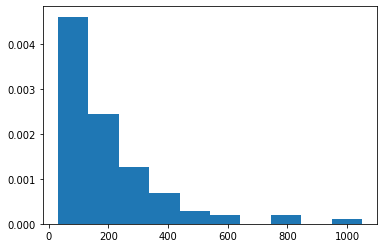

In [63]:
plt.hist(queries, density=True, bins=10)

In [567]:
import math
l2_dists = []
for index_diff in tqdm(range(SIZE)):
    diff = np.abs(adv_evo_strategy[index_diff].get_best_candidate() - x_test_correct[index_diff])
    diff = np.reshape(diff, (32, 32, 3))
    l2_dist = math.sqrt(np.sum(np.reshape(diff, (-1))**2))
    l2_dists.append(l2_dist)
#     print("L2 distance:", math.sqrt(np.sum(np.reshape(diff, (-1))**2)))
#     plt.imshow(np.reshape(adv_evo_strategy[index_diff].get_best_candidate(), (28, 28)))
#     plt.show()
#     print("Prediction:", model.predict(np.array([adv_evo_strategy[index_diff].get_best_candidate()])))

100%|██████████| 2000/2000 [00:00<00:00, 3242.27it/s]


In [574]:
import math
l2_dists_relative = []
for index_diff in tqdm(range(SIZE)):
    diff = np.abs(adv_evo_strategy[index_diff].get_best_candidate() - x_test_correct[index_diff])
    diff = np.reshape(diff, (32, 32, 3))
    l2_dist = math.sqrt(np.sum(np.reshape(diff, (-1))**2))
    l2_img = math.sqrt(np.sum(np.reshape(x_test_correct[index_diff], -1)**2))
    l2_dists_relative.append(l2_dist / l2_img)
#     print("L2 distance:", math.sqrt(np.sum(np.reshape(diff, (-1))**2)))
#     plt.imshow(np.reshape(adv_evo_strategy[index_diff].get_best_candidate(), (28, 28)))
#     plt.show()
#     print("Prediction:", model.predict(np.array([adv_evo_strategy[index_diff].get_best_candidate()])))

100%|██████████| 2000/2000 [00:00<00:00, 17442.87it/s]


In [575]:
np.mean(l2_dists_relative)

0.06574363405938638

(array([ 5., 17., 16., 13., 19.,  8., 11.,  7.,  1.,  3.]),
 array([0.42077901, 0.77582747, 1.13087592, 1.48592438, 1.84097283,
        2.19602129, 2.55106974, 2.9061182 , 3.26116665, 3.6162151 ,
        3.97126356]),
 <a list of 10 Patch objects>)

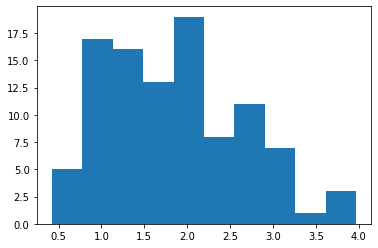

In [55]:
plt.hist(np.array(l2_dists)/255)

In [357]:
import math
linf_dists = []
for index_diff in tqdm(range(SIZE)):
    diff = np.abs(adv_evo_strategy[index_diff].get_best_candidate() - x_test_correct[index_diff])
    diff = np.reshape(diff, (32, 32, 3))
    linf_dist = np.max(diff)
    linf_dists.append(linf_dist)
#     print("L2 distance:", math.sqrt(np.sum(np.reshape(diff, (-1))**2)))
#     plt.imshow(np.reshape(adv_evo_strategy[index_diff].get_best_candidate(), (28, 28)))
#     plt.show()
#     print("Prediction:", model.predict(np.array([adv_evo_strategy[index_diff].get_best_candidate()])))

100%|██████████| 2000/2000 [00:06<00:00, 313.61it/s]


In [363]:
# NOTE: linf very high, if we took random noise at all for few pixels E() is very high: 
# https://math.stackexchange.com/questions/1696623/what-is-the-expected-value-of-the-largest-of-the-three-dice-rolls
np.mean(linf_dists)

197.0575

In [482]:
import math
l0_dists = []
for index_diff in tqdm(range(SIZE)):
    diff = np.abs(adv_evo_strategy[index_diff].get_best_candidate() - x_test_correct[index_diff])
    diff = np.reshape(diff, (32, 32, 3))
    diff = (diff!=0)
    l0_dist = np.sum(diff)
    l0_dists.append(l0_dist)
#     print("L2 distance:", math.sqrt(np.sum(np.reshape(diff, (-1))**2)))
#     plt.imshow(np.reshape(adv_evo_strategy[index_diff].get_best_candidate(), (28, 28)))
#     plt.show()
#     print("Prediction:", model.predict(np.array([adv_evo_strategy[index_diff].get_best_candidate()])))

100%|██████████| 2000/2000 [00:00<00:00, 4305.23it/s]


In [483]:
np.mean(l0_dists)

17.6635

(array([47., 25., 13.,  7.,  3.,  2.,  0.,  2.,  0.,  1.]),
 array([  3. ,  13.1,  23.2,  33.3,  43.4,  53.5,  63.6,  73.7,  83.8,
         93.9, 104. ]),
 <a list of 10 Patch objects>)

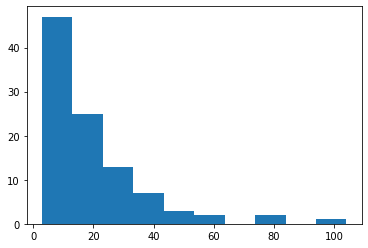

In [52]:
plt.hist(l0_dists)

array([3])

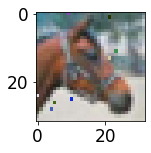

In [456]:
img_pert = adv_evo_strategy[15].get_best_candidate()
plt.figure(figsize=(2,2))
plt.imshow(img_pert.astype(int))
np.argmax(model.predict(np.array([img_pert])), axis=1)

In [469]:
cifar_label_to_text = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [470]:
keras_idx_to_name = cifar_label_to_text.copy()

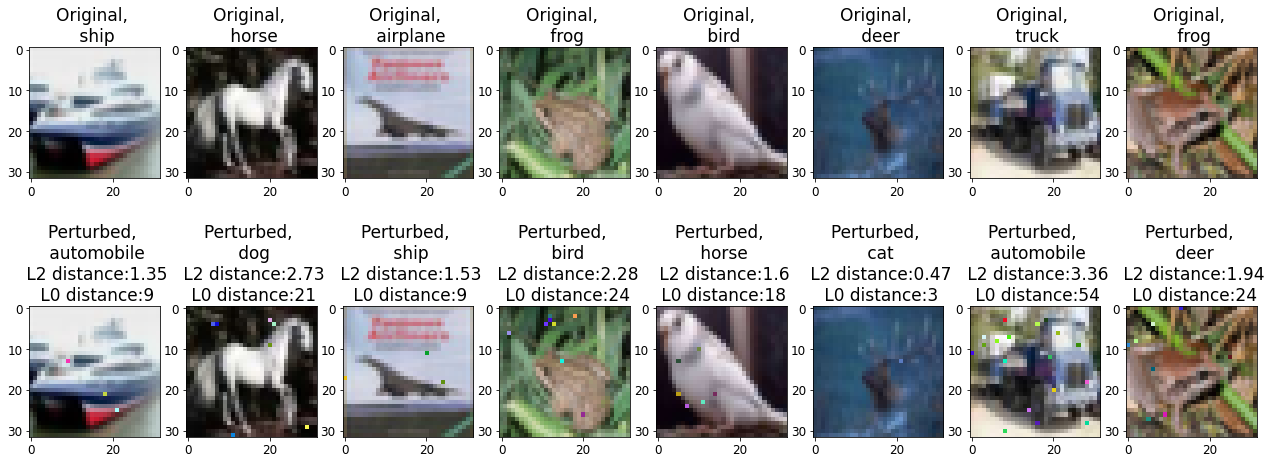

In [563]:
plt.rcParams.update({'font.size': 12})

w=10
h=10
fig=plt.figure(figsize=(22, 7))
fig.tight_layout()
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.2)

columns = 8
rows = 2
img_curr = 0
for i in range(1, columns + 1):
    img_indx = imgss[img_curr]
    initial = (keras_idx_to_name[adv_evo_strategy[img_indx].label])
    if len(initial) > 30:
        initial = initial[:21] + "\n" + initial[21:]
    fig.add_subplot(rows, columns, i)
    plt.title(f"Original, \n {initial}", fontdict={"size":17})
    img_start = adv_evo_strategy[img_indx].img.astype(int)
    plt.imshow(img_start)
    
    fig.add_subplot(rows, columns, i + columns)
    
    img_final = adv_evo_strategy[img_indx].get_best_candidate()
    predss = model.predict(np.expand_dims(img_final, axis=0))[0]
    predicted = np.argmax(predss)
    diff = math.sqrt(np.sum((img_final - img_start) **2))
    l2_distance = int((diff/(255)) * 100)/100
    l0_distance = (img_start != img_final).sum()
    final = (keras_idx_to_name[predicted])
    plt.title(f"Perturbed, \n {final}\n L2 distance:{l2_distance}\n L0 distance:{l0_distance}", fontdict={"size":17})
    plt.imshow(img_final.astype(int))
    img_curr += 1
plt.show()